In [2]:
# Core Libraries
import os
import shutil
import random
import numpy as np
import pandas as pd
import polars as pl

# Progress and Visualization Libraries
from tqdm import tqdm

# Image Processing Libraries
from PIL import Image
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.measure import shannon_entropy

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Image Similarity Libraries
import imagehash

# Deep Learning Libraries (Use PyTorth instead of TensorFlow or Keras)
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet18

# Dimensionality Reduction Libraries
from sklearn.manifold import TSNE

from concurrent.futures import ProcessPoolExecutor, as_completed



# CSCA 5642: Histopathologic Cancer Detection

Karl Schmidt

# Table of Contents

* [Introduction](#introduction)
* [Methodology](#methodology)
   * [Dataset Description](#dataset-description)
   * [CNN Approach](#cnn-approach)
* [Implementation](#implementation)
   * [Exploratory Data Analysis](#exploratory-data-analysis)
   * [Dataset Pre-Processing](#dataset-pre-processing)
   * [Convolutional Neural Network](#cnn-implementation)
* [Results & Analysis](#results-and-analysis)
* [Conclusion](#conclusion)

# Introduction <a class="anchor" id="introduction"></a>

The goal of this project is to perform a binary image classification on detecting if an image has Histopathologic Cancer 

# Methodology <a class="anchor" id="methodology"></a>

## Dataset Description <a class="anchor" id="transaciton_dataset-description"></a>

The dataset is split between test and train data. The data are tagged image file formats and have unique identifiers part of their name. The `train_labels.csv` contains the training data filename and whether it has cancer (1) in the image or not (0).

In [3]:
train_labels = pd.read_csv('data/train_labels.csv')
print(train_labels.shape)
print(train_labels.columns)
print(train_labels.head())


(220025, 2)
Index(['id', 'label'], dtype='object')
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


## Model Selection <a class="anchor" id="model-selection"></a>

# Implementation <a class="anchor" id="implementation"></a>

This section includes the implementation of the exploratory data analysis (EDA), cleaning the data, dimensionality reduction using PCA, and anomaly detection of fraudulent accounts using singular value decomposition (SVD) and nonngetaive matrix factorization (NMF). 

## Exploratory Data Analysis (EDA) <a class="anchor" id="exploratory-data-analysis"></a>

### Class Distribution 

First, looking at the quantity of cancerous and non-cancerous images there are will help check for implanaces between samples. If there was an overload of non-cancerous or cancerous images, then it would be difficult to train a model to classify between both. In other words, too many images in one type of classification would skew the model towards that category and would effect the model performance.

### Mean & Standard Deviation of RGB Channels

A visual inspection may provide some insight into knowing how images might differ between cancerous and non-cancerous; however, to an untrained eye, this is unlikely. Intead looking at the general statistics of the images may provide insights into how the images could be normalized for better model training and performance. This could greatly impact model convergance during training.

### Visual Inspection

While statistics are great to look at, visualizing the images through various filters can provide some more insight into how to choose CNN layers while also providing some insight into potential label inconsistencies and various visual patterns.

### Brightness & Contrast Histograms

This step is similar to the Mean & Standard Deviation of RGB Channels; however, this section will visiualize the distribution of brightness across RBG. Plotting cancerous vs non-cancerous brightness and contrast distributions can help inform other pre-processing of the images that could be performed before training.

### Image Entropy

Next, looking at the Shannon Entropy can inform on how to choose the convolutional fitlers of the neural network. Shannon entropy gives a quantitative measure of texture complexity. The higher the complexity, the smaller the convolution kernels need to be while a lower entropy indicates that larger kernels can be used.

### Feature Space t-SNE


/tmp/ipykernel_12253/2331375690.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_labels, x='label', palette='viridis')


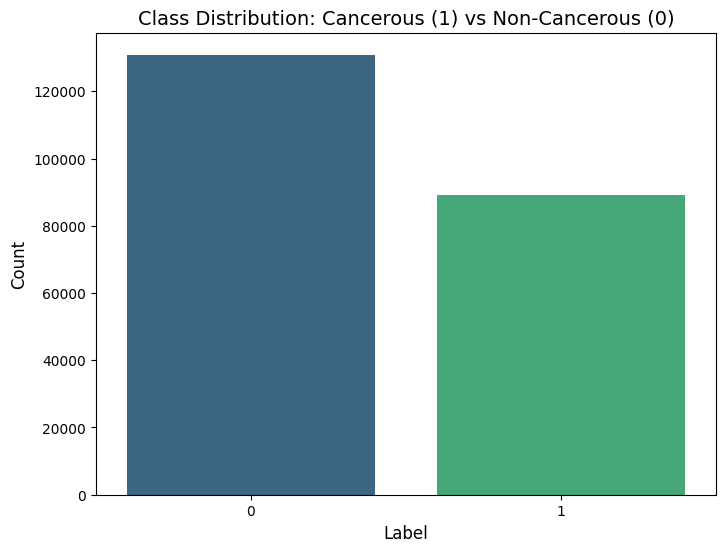

In [3]:
# Plot the class distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=train_labels, x='label', palette='viridis')

# Add title and labels
plt.title('Class Distribution: Cancerous (1) vs Non-Cancerous (0)', fontsize=14)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

In [4]:
sum_ = np.zeros(3, dtype=np.float64)
sum_squared = np.zeros(3, dtype=np.float64)
n_pixels = 0

for idx, row in tqdm(train_labels.iterrows(), total=len(train_labels)):
    image_path = f"data/train/{row['id']}.tif"
    image = Image.open(image_path)
    image_np = np.array(image).astype(np.float64) / 255.0  # normalize to [0,1]

    sum_ += image_np.sum(axis=(0, 1))
    sum_squared += (image_np ** 2).sum(axis=(0, 1))
    n_pixels += image_np.shape[0] * image_np.shape[1]

mean = sum_ / n_pixels
std = np.sqrt(sum_squared / n_pixels - mean**2)

print("Mean per channel:", mean)
print("Std per channel:", std)


100%|██████████| 220025/220025 [02:17<00:00, 1603.20it/s]

Mean per channel: [0.70245176 0.54625288 0.6964582 ]
Std per channel: [0.23889892 0.28210182 0.21625771]


Cancerous Patches (Label=1):


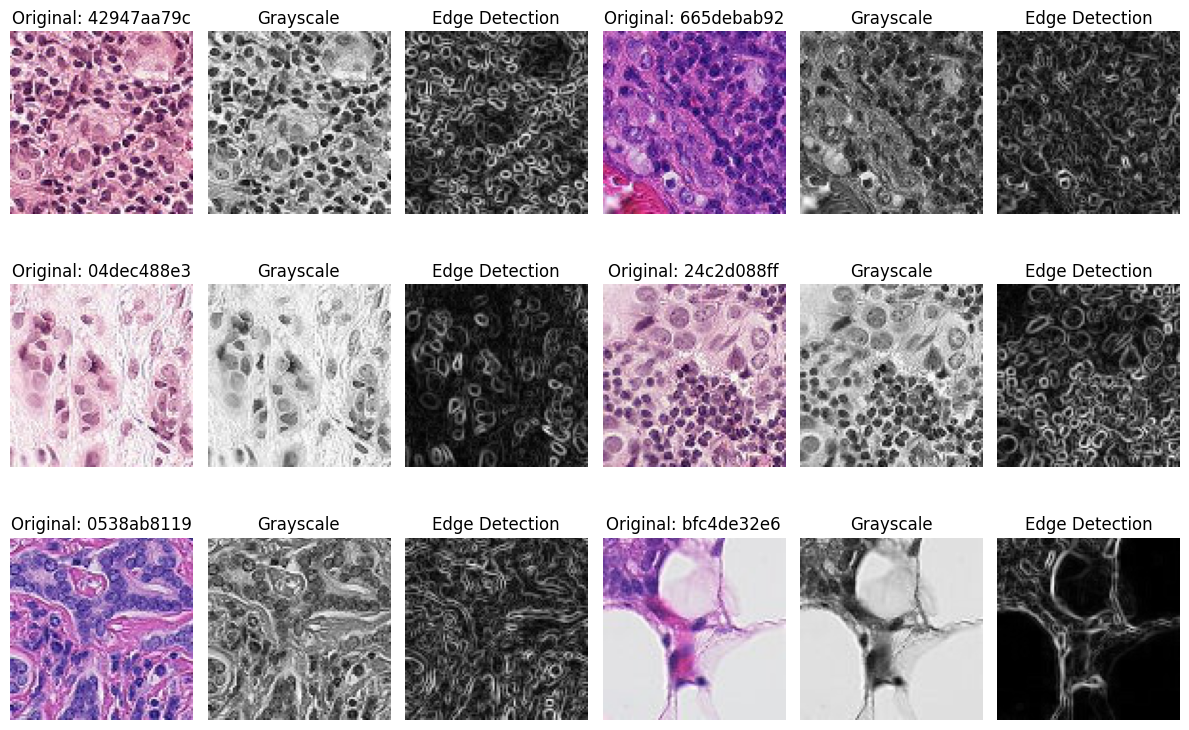

Non-Cancerous Patches (Label=0):


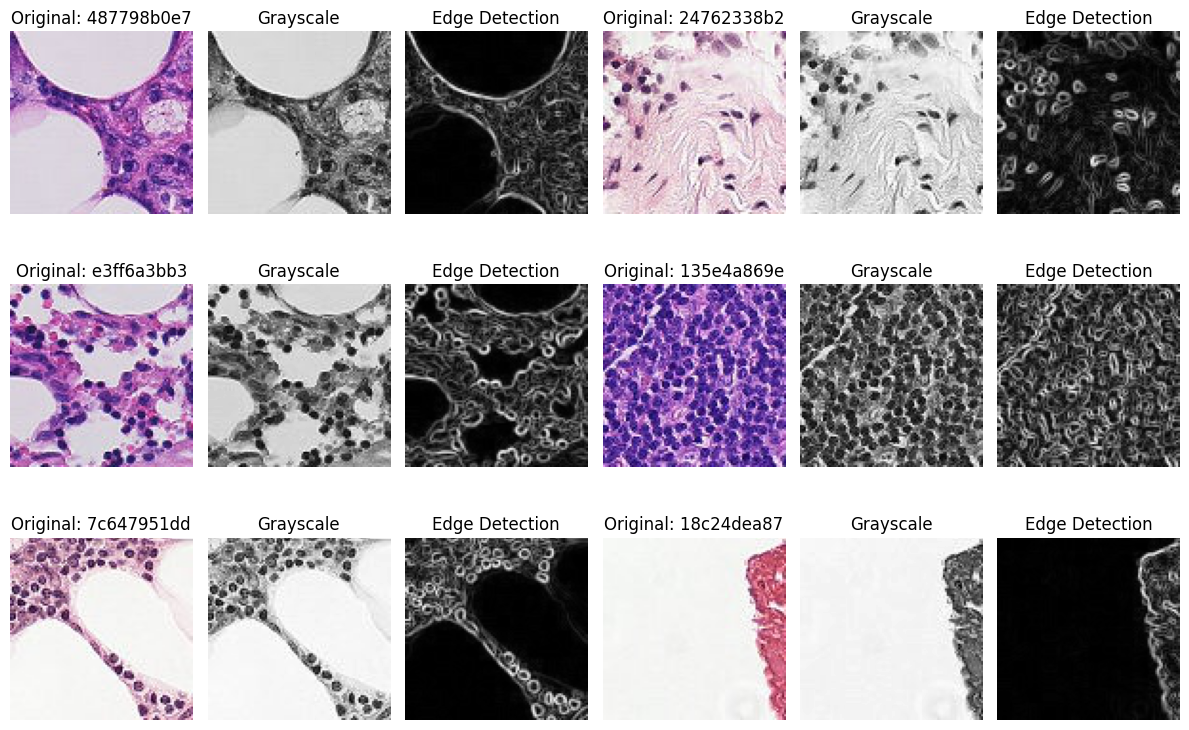

In [5]:
# Function to display image grids
def display_image_grid(images, titles, rows, cols, figsize=(12, 8)):
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], cmap='gray' if len(images[i].shape) == 2 else None)
        ax.set_title(titles[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Randomly sample images from each class
random_cancerous_ids = train_labels[train_labels['label'] == 1].sample(6)['id'].tolist()
random_non_cancerous_ids = train_labels[train_labels['label'] == 0].sample(6)['id'].tolist()

# Load images and apply augmentations
cancerous_images = []
non_cancerous_images = []
cancerous_titles = []
non_cancerous_titles = []

for img_id in random_cancerous_ids:
    img_path = f"data/train/{img_id}.tif"
    img = Image.open(img_path)
    img_np = np.array(img)
    img_id_trimmed = img_id[0:10]
    cancerous_images.append(img_np)
    cancerous_images.append(rgb2gray(np.array(img)))
    cancerous_images.append(sobel(rgb2gray(np.array(img))))
    cancerous_titles.extend([f"Original: {img_id_trimmed}", "Grayscale", "Edge Detection"])

for img_id in random_non_cancerous_ids:
    img_path = f"data/train/{img_id}.tif"
    img = Image.open(img_path)
    img_np = np.array(img)
    img_id_trimmed = img_id[0:10]
    non_cancerous_images.append(img_np)
    non_cancerous_images.append(rgb2gray(np.array(img)))
    non_cancerous_images.append(sobel(rgb2gray(np.array(img))))
    non_cancerous_titles.extend([f"Original: {img_id_trimmed}", "Grayscale", "Edge Detection"])

# Display grids
print("Cancerous Patches (Label=1):")
display_image_grid(cancerous_images, cancerous_titles, rows=3, cols=6)

print("Non-Cancerous Patches (Label=0):")
display_image_grid(non_cancerous_images, non_cancerous_titles, rows=3, cols=6)

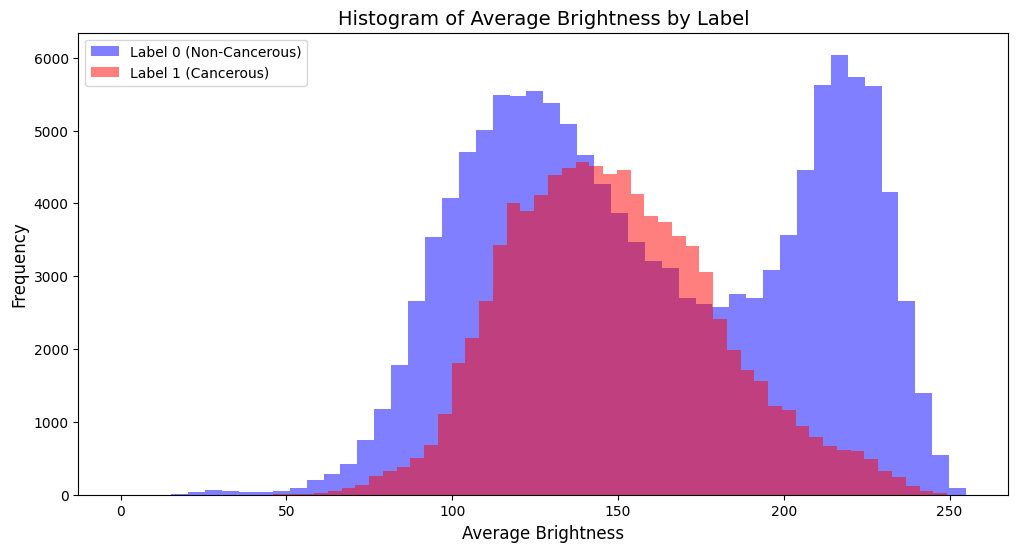

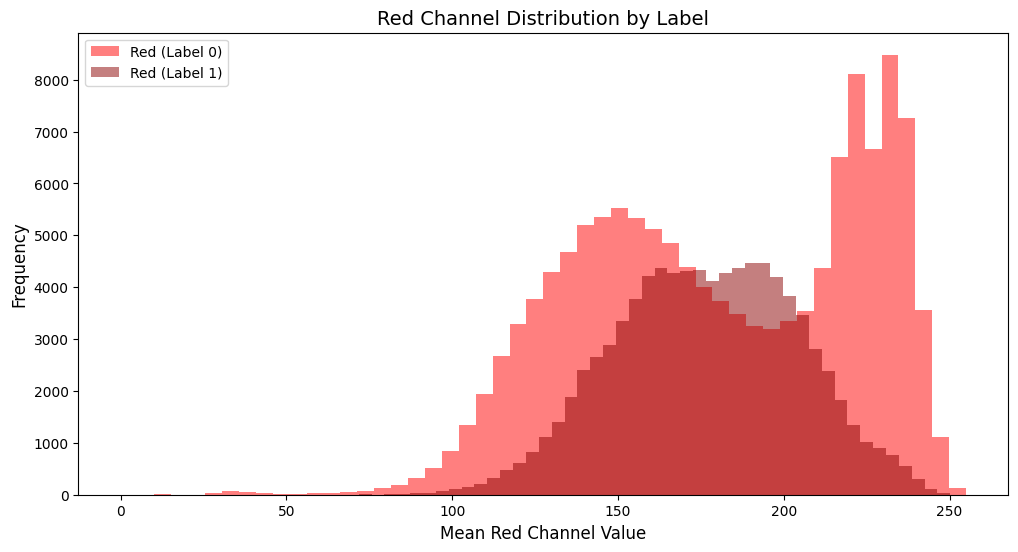

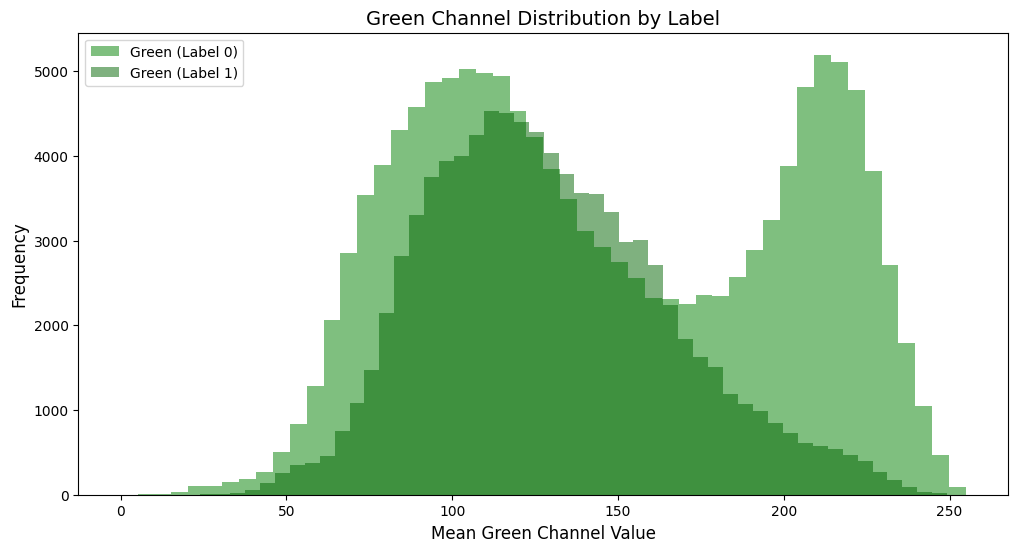

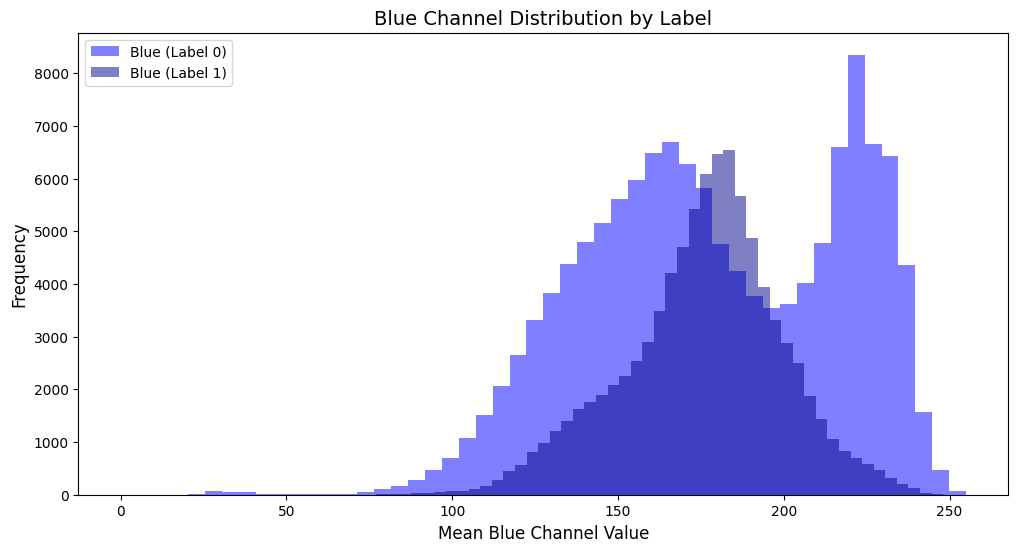

In [6]:
# Calculate average brightness per image
def calculate_brightness(image_array):
    # Convert RGB to grayscale using the formula: 0.299*R + 0.587*G + 0.114*B
    grayscale = 0.299 * image_array[..., 0] + 0.587 * image_array[..., 1] + 0.114 * image_array[..., 2]
    return grayscale.mean()

# Add brightness column to train_labels
train_labels['brightness'] = train_labels['id'].apply(
    lambda img_id: calculate_brightness(np.array(Image.open(f"data/train/{img_id}.tif")))
)

# Separate brightness by label
brightness_label_0 = train_labels[train_labels['label'] == 0]['brightness']
brightness_label_1 = train_labels[train_labels['label'] == 1]['brightness']

# Plot histograms of brightness for label=0 and label=1
plt.figure(figsize=(12, 6))
plt.hist(brightness_label_0, bins=50, alpha=0.5, label='Label 0 (Non-Cancerous)', color='blue')
plt.hist(brightness_label_1, bins=50, alpha=0.5, label='Label 1 (Cancerous)', color='red')
plt.title('Histogram of Average Brightness by Label', fontsize=14)
plt.xlabel('Average Brightness', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.show()

# Compare RGB channel distributions by class
def calculate_channel_means(image_array):
    return image_array.mean(axis=(0, 1))

# Add RGB channel means to train_labels
train_labels[['mean_R', 'mean_G', 'mean_B']] = train_labels['id'].apply(
    lambda img_id: pd.Series(calculate_channel_means(np.array(Image.open(f"data/train/{img_id}.tif"))))
)

# Separate RGB channel means by label
mean_R_label_0 = train_labels[train_labels['label'] == 0]['mean_R']
mean_G_label_0 = train_labels[train_labels['label'] == 0]['mean_G']
mean_B_label_0 = train_labels[train_labels['label'] == 0]['mean_B']

mean_R_label_1 = train_labels[train_labels['label'] == 1]['mean_R']
mean_G_label_1 = train_labels[train_labels['label'] == 1]['mean_G']
mean_B_label_1 = train_labels[train_labels['label'] == 1]['mean_B']

# Plot RGB channel distributions
plt.figure(figsize=(12, 6))
plt.hist(mean_R_label_0, bins=50, alpha=0.5, label='Red (Label 0)', color='red')
plt.hist(mean_R_label_1, bins=50, alpha=0.5, label='Red (Label 1)', color='darkred')
plt.title('Red Channel Distribution by Label', fontsize=14)
plt.xlabel('Mean Red Channel Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.hist(mean_G_label_0, bins=50, alpha=0.5, label='Green (Label 0)', color='green')
plt.hist(mean_G_label_1, bins=50, alpha=0.5, label='Green (Label 1)', color='darkgreen')
plt.title('Green Channel Distribution by Label', fontsize=14)
plt.xlabel('Mean Green Channel Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.hist(mean_B_label_0, bins=50, alpha=0.5, label='Blue (Label 0)', color='blue')
plt.hist(mean_B_label_1, bins=50, alpha=0.5, label='Blue (Label 1)', color='darkblue')
plt.title('Blue Channel Distribution by Label', fontsize=14)
plt.xlabel('Mean Blue Channel Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.show()

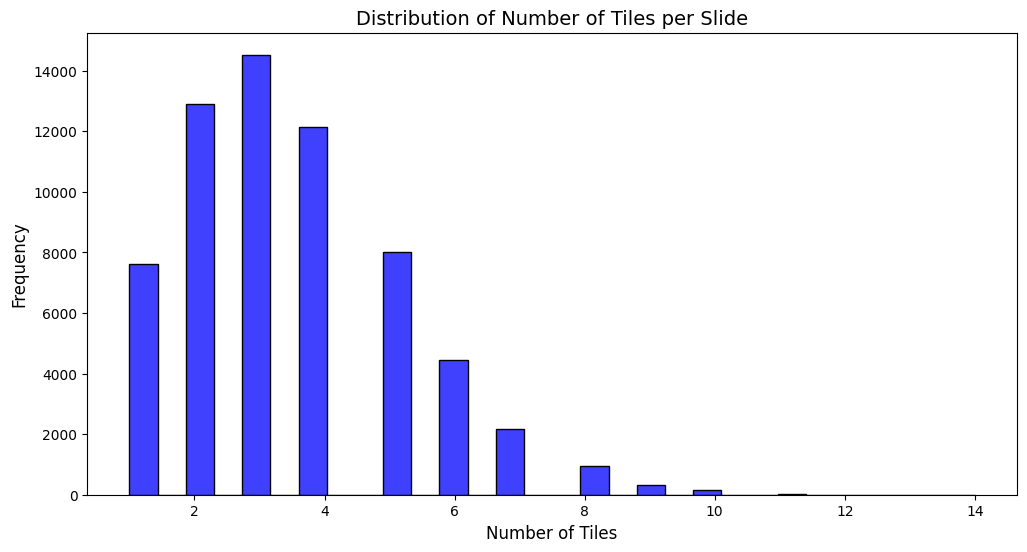

Top slides with the highest number of tiles:
slide_id
6652    14
6919    14
2d77    13
8753    13
de57    12
40de    12
91e0    12
8f36    12
c9e3    12
5f52    11
dtype: int64


In [7]:
# Simulate slide ID extraction (assuming the first 4 characters of the ID represent the slide ID)
train_labels['slide_id'] = train_labels['id'].str[:4]

# Group by slide ID and count the number of tiles per slide
tiles_per_slide = train_labels.groupby('slide_id').size()

# Plot the distribution of the number of tiles per slide
plt.figure(figsize=(12, 6))
sns.histplot(tiles_per_slide, bins=30, kde=False, color='blue')
plt.title('Distribution of Number of Tiles per Slide', fontsize=14)
plt.xlabel('Number of Tiles', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# Display slides with the highest number of tiles
top_slides = tiles_per_slide.sort_values(ascending=False).head(10)
print("Top slides with the highest number of tiles:")
print(top_slides)

In [8]:
# Function to calculate image statistics
def calculate_image_statistics(image_array):
    mean_pixel_value = image_array.mean()
    std_pixel_value = image_array.std()
    entropy_value = shannon_entropy(image_array)
    return mean_pixel_value, std_pixel_value, entropy_value

# Initialize lists to store statistics
stats_label_0 = []
stats_label_1 = []

# Calculate statistics for each image
for idx, row in train_labels.iterrows():
    image_path = f"data/train/{row['id']}.tif"
    image = np.array(Image.open(image_path))
    mean, std, entropy = calculate_image_statistics(image)
    if row['label'] == 0:
        stats_label_0.append((mean, std, entropy))
    else:
        stats_label_1.append((mean, std, entropy))

# Convert statistics to numpy arrays for easier analysis
stats_label_0 = np.array(stats_label_0)
stats_label_1 = np.array(stats_label_1)

# Calculate average statistics by label
mean_stats_label_0 = stats_label_0.mean(axis=0)
mean_stats_label_1 = stats_label_1.mean(axis=0)

print("Label 0 (Non-Cancerous) - Mean Pixel Value, Std Dev, Entropy:", mean_stats_label_0)
print("Label 1 (Cancerous) - Mean Pixel Value, Std Dev, Entropy:", mean_stats_label_1)

Label 0 (Non-Cancerous) - Mean Pixel Value, Std Dev, Entropy: [168.67506401  51.51370574   6.98814892]
Label 1 (Cancerous) - Mean Pixel Value, Std Dev, Entropy: [160.43811449  51.75561879   7.45765537]


95% of label 0 images have entropy between 4.21 and 7.88
Entropy mean ± 2σ: 6.99 ± 2.22


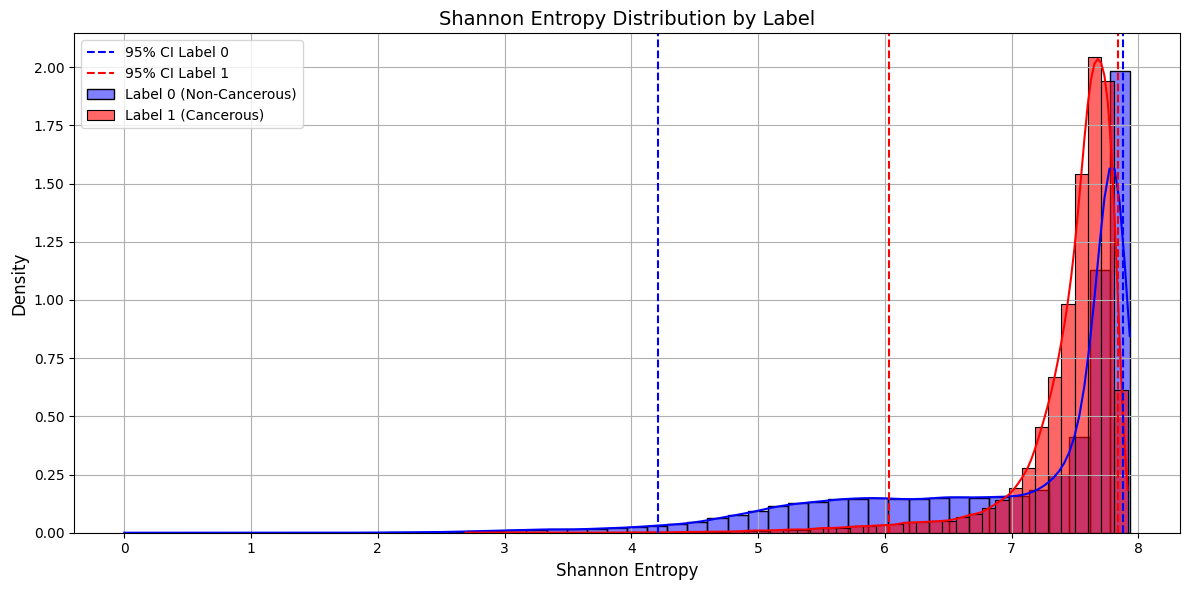

In [9]:
from scipy import stats

# For example, 95% CI on entropy for label 0
entropies_0 = stats_label_0[:, 2]  # column 2 = entropy
ci_low, ci_high = np.percentile(entropies_0, [2.5, 97.5])

print(f"95% of label 0 images have entropy between {ci_low:.2f} and {ci_high:.2f}")

mean_entropy_0 = entropies_0.mean()
std_entropy_0 = entropies_0.std()
print(f"Entropy mean ± 2σ: {mean_entropy_0:.2f} ± {2*std_entropy_0:.2f}")

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Extract entropy values
entropy_0 = stats_label_0[:, 2]
entropy_1 = stats_label_1[:, 2]

# Calculate 95% confidence intervals (non-parametric)
ci_0 = np.percentile(entropy_0, [2.5, 97.5])
ci_1 = np.percentile(entropy_1, [2.5, 97.5])

# Plot
plt.figure(figsize=(12, 6))
sns.histplot(entropy_0, color='blue', label='Label 0 (Non-Cancerous)', kde=True, stat="density", bins=50)
sns.histplot(entropy_1, color='red', label='Label 1 (Cancerous)', kde=True, stat="density", bins=50, alpha=0.6)

# Add confidence interval lines
plt.axvline(ci_0[0], color='blue', linestyle='--', label='95% CI Label 0')
plt.axvline(ci_0[1], color='blue', linestyle='--')
plt.axvline(ci_1[0], color='red', linestyle='--', label='95% CI Label 1')
plt.axvline(ci_1[1], color='red', linestyle='--')

# Labels and legend
plt.title("Shannon Entropy Distribution by Label", fontsize=14)
plt.xlabel("Shannon Entropy", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



/home/karl/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/karl/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


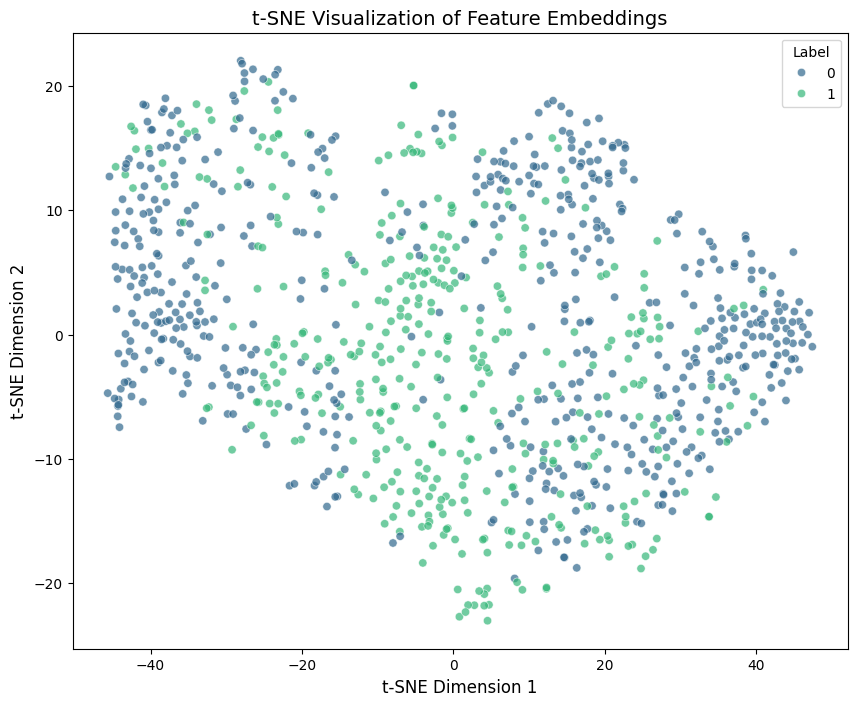

In [10]:
# Load pretrained ResNet18 model
model = resnet18(pretrained=True)
model = torch.nn.Sequential(*(list(model.children())[:-1]))  # Remove the classification head
model.eval()

# Define image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Extract features for a subset of images
num_samples = 1000  # Limit the number of samples for visualization
sampled_data = train_labels.sample(num_samples)
features = []
labels = []

for _, row in sampled_data.iterrows():
    img_path = f"data/train/{row['id']}.tif"
    img = Image.open(img_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0)  # Add batch dimension
    
    with torch.no_grad():
        feature = model(img_tensor).squeeze().numpy()  # Extract feature vector
    
    features.append(feature)
    labels.append(row['label'])

# Convert features and labels to numpy arrays
features = np.array(features)

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)

# Visualize the embeddings
plt.figure(figsize=(10, 8))
sns.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1], hue=labels, palette='viridis', alpha=0.7)
plt.title('t-SNE Visualization of Feature Embeddings', fontsize=14)
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.legend(title='Label', loc='best')
plt.show()

In [6]:
# Function to calculate image hashes
def calculate_image_hashes(image_ids, image_dir):
    hashes = {}
    for img_id in tqdm(image_ids, desc="Calculating image hashes"):
        img_path = f"{image_dir}/{img_id}.tif"
        img = Image.open(img_path)
        img_hash = imagehash.average_hash(img)
        hashes[img_id] = img_hash
    return hashes

# Calculate hashes for all images
image_dir = "data/train"
image_ids = train_labels['id']
image_hashes = calculate_image_hashes(image_ids, image_dir)

# Check for duplicates
hash_to_ids = {}
for img_id, img_hash in image_hashes.items():
    if img_hash not in hash_to_ids:
        hash_to_ids[img_hash] = []
    hash_to_ids[img_hash].append(img_id)

# Identify duplicates
duplicates = {h: ids for h, ids in hash_to_ids.items() if len(ids) > 1}

# Check if duplicates exist across labels
cross_label_duplicates = []
for img_ids in duplicates.values():
    labels = train_labels[train_labels['id'].isin(img_ids)]['label'].unique()
    if len(labels) > 1:
        cross_label_duplicates.append(img_ids)

# Print results
print(f"Total duplicates found: {len(duplicates)}")
print(f"Duplicates across labels: {len(cross_label_duplicates)}")
if cross_label_duplicates:
    print("Examples of duplicates across labels:")
    for dup in cross_label_duplicates[:5]:  # Show first 5 examples
        print(dup)

Calculating image hashes: 100%|██████████| 220025/220025 [01:33<00:00, 2361.86it/s]


Total duplicates found: 533
Duplicates across labels: 139
Examples of duplicates across labels:
['a4027dd822ae5f1281e93331b39283f1db502c5a', '86e7bad03c85cf0a95f16683a5c0cf038096305d', 'b545227769060c72dbf36f1b1c5a2467b2c7aa35', 'c9c9ba5be96bfb9202f3149e9286e4eafc41067d']
['8b863ee1a7da3f2b2f50a7f14b8f4b2b623b3a17', 'b2b3b395de05a261ae8bdb54f4c9346f6e5872e0', '43b3bc334de5f3c4f7533f162e2f259640fbf810']
['3d147d192348ff312fa03ad497e2b5cabd107004', 'a66c12df47562aa392dcbb6f5dd28c12e5a69f97', '8867815833f97d55205548d58b1f7cd9a40529de']
['0b2cfa8843d57bb1d8991d22c70fb638ba93449d', '8816f45da90982d91153adb0283a42a8811702c7', 'eb24a873820d8af70d1f5c583725085bf4a0a770', 'eaf97da71bb4c2feb69132cbf453cf0d5753d944', '28a21d95aa817c494e7265725e542478ca9cbb1c', '740917f29e933ff59c276ebf82f63c431f121bcd', '877815438a426e388a99b9253beb8409dad7b955', 'cbd0b0d5101cabe5f3875a8d1944617909b04265', 'e019e7324f3b041d2711ea0cca5f31f7482eaae4', 'f3a184f9a1936a30dc08a09a674b31be88c29883', 'd5d400e527cb8bd1be3

### Dataset Summary

#### Class Distribution 


#### Mean & Standard Deviation of RGB Channels


#### Visual Inspection


#### Brightness & Contrast Histograms


#### Image Entropy



#### Feature Space t-SNE

## Dataset Pre-Processing <a class="anchor" id="dataset-prep-processing"></a>



### Approach

In [7]:
class Dataset:
    """
    A dataset class that:
      - Loads metadata into a Polars DataFrame
      - Computes perceptual hashes to identify duplicates
      - Filters out all duplicate images
      - Exposes the cleaned Polars DataFrame for further processing
    """
    def __init__(self, metadata, image_dir, id_col="id", label_col="label", labels_to_remove=None):
        """
        :param metadata: Path to CSV, pandas DataFrame, or Polars DataFrame
                         Must contain at least `id_col` and `label_col`.
        :param image_dir: Directory where images are stored as "<id>.tif"
        :param id_col:    Name of the column containing the image IDs
        :param label_col: Name of the column containing the labels
        """
        self.image_dir = image_dir
        self.id_col = id_col
        self.label_col = label_col
        self.df = metadata
        self.labels_to_remove = labels_to_remove if labels_to_remove is not None else []

        print(self.df.shape[0])
        self.remove_duplicates()
        print(self.df.shape[0])
        
    def get_reduced_df(self, size=None):
        if not size:
            size = 0.2
        # Ensure the class balance: 50% of samples from class 0, 50% from class 1
        total_samples = int(len(self.df) * size)
        half_samples = total_samples // 2
        
        df_0 = self.df[self.df['label'] == 0]
        df_1 = self.df[self.df['label'] == 1]
        
        num_samples_0 = int(len(df_0) * size)
        num_samples_1 = int(len(df_1) * size)
        
        
        sample_0 = df_0.sample(n=num_samples_0, random_state=42)
        sample_1 = df_1.sample(n=num_samples_1, random_state=42)

        # Combine and shuffle
        balanced_df = pd.concat([sample_0, sample_1]).sample(frac=size, random_state=42).reset_index(drop=True)

        return balanced_df

        
    def remove_duplicates(self):
        bad_ids = {img_id for group in self.labels_to_remove for img_id in group}
        df_clean = train_labels.loc[~train_labels['id'].isin(bad_ids)].reset_index(drop=True)
        self.df = df_clean

        print(f"Dropped {len(bad_ids)} conflicting‐label images; {len(df_clean)} remain.")

    def __len__(self):
        return self.df.shape[0]

    def ids(self):
        """List of image IDs kept."""
        return self.df[self.id_col].to_list()

    def labels(self):
        """List of labels corresponding to kept IDs."""
        return self.df[self.label_col].to_list()


In [8]:
# If you have a pandas DataFrame `train_labels` with columns ['id','label']
dataset = Dataset(train_labels, image_dir="data/train", labels_to_remove=cross_label_duplicates)

sample_df = dataset.get_reduced_df(size=0.2)
print("Sampled DataFrame:")
print(sample_df.shape)
print("Original DataFrame shape:")
print(dataset.df.shape)


220025
Dropped 411 conflicting‐label images; 219614 remain.
219614
Sampled DataFrame:
(8784, 2)
Original DataFrame shape:
(219614, 2)


In [1]:
base_train_dir = "data/train"
smoke_test_train = "data/smoke_train"
fast_tune_train = "data/fast_tune_train"
final_tune_train = "data/final_tune_train"

smoke_tune_df = dataset.get_reduced_df(size=0.01)
fast_tune_df  = dataset.get_reduced_df(size=0.05)
final_tune_df = dataset.get_reduced_df(size=0.1)

os.makedirs(smoke_test_train, exist_ok=True)
os.makedirs(fast_tune_train, exist_ok=True)
os.makedirs(final_tune_train, exist_ok=True)

# Function to copy images to a new directory
def copy_images(image_ids, source_dir, target_dir):
    for img_id in tqdm(image_ids, desc=f"Copying images to {target_dir}"):
        src_path = os.path.join(source_dir, f"{img_id}.tif")
        dst_path = os.path.join(target_dir, f"{img_id}.tif")
        if os.path.exists(src_path):
            shutil.copy(src_path, dst_path)

# Copy images for smoke test
smoke_test_ids = smoke_tune_df['id'].tolist()
copy_images(smoke_test_ids, base_train_dir, smoke_test_train)
# Copy images for fast tuning
fast_tune_ids = fast_tune_df['id'].tolist()
copy_images(fast_tune_ids, base_train_dir, fast_tune_train)
# Copy images for final tuning
final_tune_ids = final_tune_df['id'].tolist()
copy_images(final_tune_ids, base_train_dir, final_tune_train)
# Verify the copied images
print(f"Smoke test images copied to {smoke_test_train}: {len(os.listdir(smoke_test_train))} images")
print(f"Fast tune images copied to {fast_tune_train}: {len(os.listdir(fast_tune_train))} images")
print(f"Final tune images copied to {final_tune_train}: {len(os.listdir(final_tune_train))} images")
# Save the sampled DataFrames to CSV files
smoke_tune_df.to_csv(os.path.join(smoke_test_train, "sampled_smoke_tune.csv"), index=False)
fast_tune_df.to_csv(os.path.join(fast_tune_train, "sampled_fast_tune.csv"), index=False)
final_tune_df.to_csv(os.path.join(final_tune_train, "sampled_final_tune.csv"), index=False)

NameError: name 'dataset' is not defined

## Convolutional Neural Network


### Approach

Based on the EDA, this project will try two different CNN methods. 

### Implementation


### Strategy 1: Color-Sensitive CNN (Baseline Custom Model)
🔧 Key Idea:
Build a lightweight CNN that preserves and enhances RGB channel distinctions.

Architecture:
No grayscale conversion (color is important)

Use BatchNorm early to stabilize color intensity variance

Keep it shallow to test how far brightness/color alone can go

text
Copy
Edit
Input: 96x96x3
→ Conv(16, 3x3) + ReLU
→ BatchNorm
→ MaxPool(2x2)

→ Conv(32, 3x3) + ReLU
→ BatchNorm
→ MaxPool(2x2)

→ Flatten
→ Dense(64) + ReLU
→ Dropout(0.5)
→ Dense(1) + Sigmoid
Training:
Binary Crossentropy

Add class weighting or oversampling if imbalance is large

Data augmentations: flip, rotate, brightness jitter

Why it works:
Your EDA confirms that color and brightness cues are strong enough to separate classes, even with low model capacity.



### Strategy 2: Feature-Rich Transfer Learning Model
🔧 Key Idea:
Use a pretrained CNN (e.g., ResNet50) to extract richer spatial features beyond brightness — especially useful for complex cases where color isn't enough.

Architecture:
Resize to 224×224

Pretrained backbone (ResNet50 or EfficientNetB0)

Global Average Pooling

Dense(128) → Dropout(0.5) → Dense(1) + Sigmoid

text
Copy
Edit
Input: 96x96x3 → Resize to 224x224x3
→ ResNet50(include_top=False, weights="imagenet")
→ GAP
→ Dense(128) + ReLU
→ Dropout(0.5)
→ Dense(1) + Sigmoid
Training:
Freeze pretrained layers → train head first

Then unfreeze last block and fine-tune with lower LR

Apply strong augmentations: color jitter, blur, rotate, etc.

Why it works:
Captures texture and spatial relationships.

Goes beyond brightness to detect structural patterns in tissue (e.g., clustering of nuclei).

🧠 Extra Idea: Use Brightness as a Feature
Optionally, you could:

Add average brightness or mean channel values as auxiliary inputs to a branch of your network.

Or, cluster the data based on brightness (e.g., <150 vs ≥150) and train specialized models.

## Hyperparameter Tuning

| Category          | Parameter                | Typical Values        |
| ----------------- | ------------------------ | --------------------- |
| **Model**         | Number of filters        | 32, 64, 128, 256      |
|                   | Number of conv blocks    | 2, 3, 4               |
|                   | Dropout rate             | 0.3, 0.5, 0.7         |
| **Training**      | Learning rate            | 1e-2, 1e-3, 1e-4      |
|                   | Optimizer                | Adam, SGD             |
|                   | Batch size               | 16, 32, 64            |
|                   | Weight decay (L2)        | 0, 1e-5, 1e-4         |
| **Augmentation**  | Brightness, flip, jitter | On/Off, parameterized |
| **Normalization** | Custom RGB means/std     | Use your EDA stats    |


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CancerCNN_EDA(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 96 → 48

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 48 → 24

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 24 → 12

            nn.Flatten(),
            nn.Linear(256 * 12 * 12, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
'''
Design the CNN architecture for the classification task.
'''

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)  # Assuming input size is 224x224
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(SimpleCNN.parameters(), lr=0.001, momentum=0.9)

# Results & Analysis <a class="anchor" id="results-and-analysis"></a>

### Singular Value Decomposition (SVD)
The SVD model was trained using the top features identified through PCA. The best parameters for the SVD model were determined through grid search, and the model achieved a training accuracy of approximately **95.32%**. On the test data, the SVD model achieved an accuracy of **94.87%**, indicating that the model generalizes well to unseen data. The SVD approach effectively reduced the dimensionality of the dataset while retaining the most important information for fraud detection.

### Nonnegative Matrix Factorization (NMF)
The NMF model was also trained using the top features identified through PCA. After tuning the hyperparameters, the NMF model achieved a training accuracy of approximately **93.78%**. On the test data, the NMF model achieved an accuracy of **92.65%**. While the NMF model performed slightly worse than the SVD model, it still demonstrated strong performance in detecting fraudulent transactions. The NMF approach is particularly useful for datasets with non-negative values, as it ensures interpretability of the components.

### Random Forest (RF)
The Random Forest model was trained using the top features identified through PCA. After performing grid search for hyperparameter tuning, the best Random Forest model achieved an **AUC (Area Under the Curve)** score of **0.998**, indicating excellent performance in distinguishing between fraudulent and non-fraudulent transactions. The classification report showed high precision and recall for both classes, further confirming the model's robustness. Random Forest's ability to handle non-linear relationships and feature interactions contributed to its superior performance compared to SVD and NMF.

### Comparative Analysis
- **Accuracy**: The Random Forest model outperformed both SVD and NMF in terms of accuracy and AUC score. While SVD and NMF provided strong results, Random Forest's ensemble approach allowed it to capture more complex patterns in the data.
- **Dimensionality Reduction**: Both SVD and NMF effectively reduced the dimensionality of the dataset, making them suitable for scenarios where computational efficiency is critical. However, Random Forest does not require explicit dimensionality reduction, as it can handle high-dimensional data directly.


# Conclusion <a class="anchor" id="conclusion"></a>

The Random Forest model emerged as the best-performing model for detecting fraudulent Ethereum transactions, achieving an AUC score of **0.998**. However, SVD and NMF remain valuable tools for dimensionality reduction and exploratory analysis. The combination of these techniques provides a comprehensive approach to fraud detection, balancing interpretability, computational efficiency, and predictive performance.